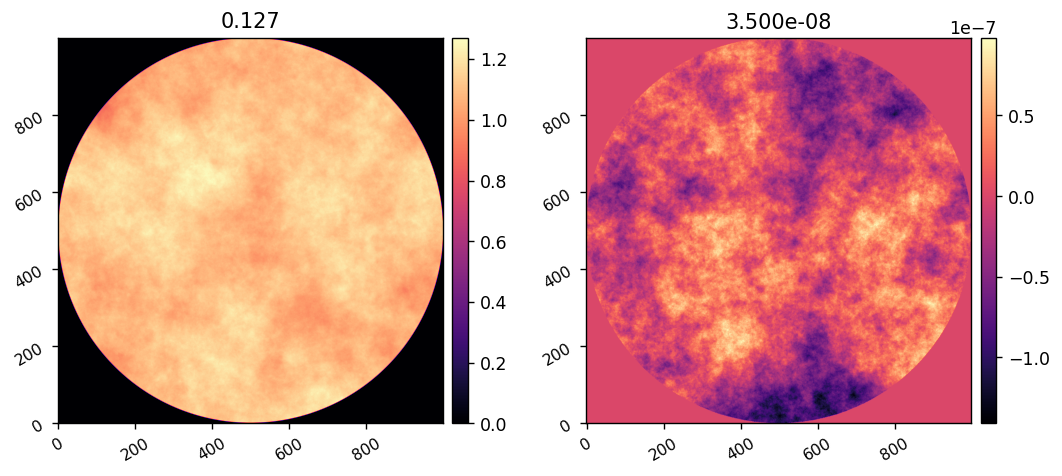

In [101]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import skimage

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = 650e-9/2/np.pi * xp.angle(WFE)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

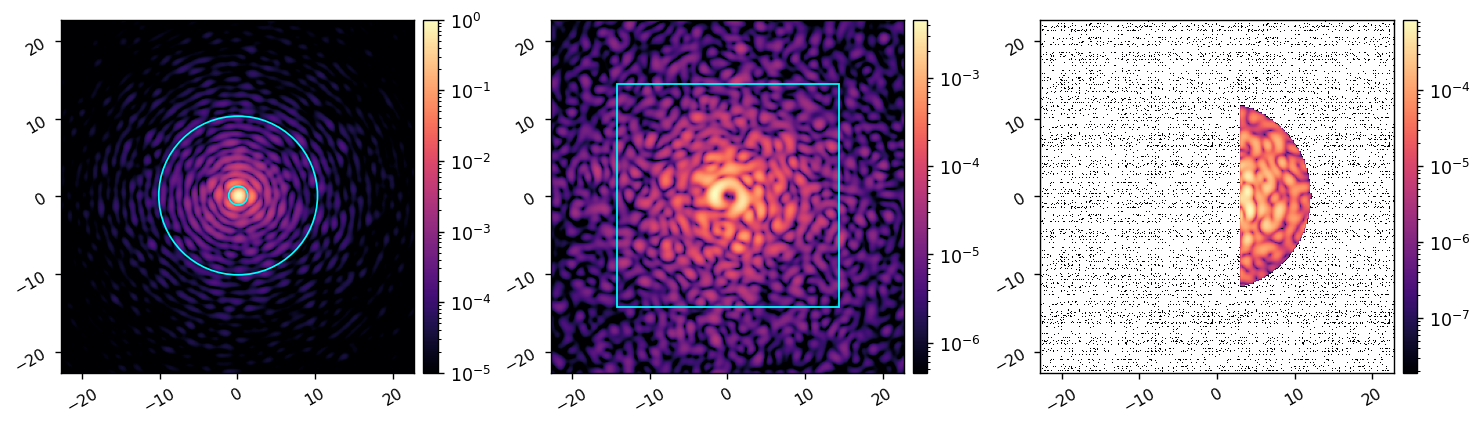

In [151]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE
m.det_rotation = 0
m.npsf = 256

m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = xp.abs(m.forward(acts, use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow3(ref_psf/m.Imax_ref, ref_coro_im, m.control_mask*ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True,  vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)

In [174]:
34/10

3.4

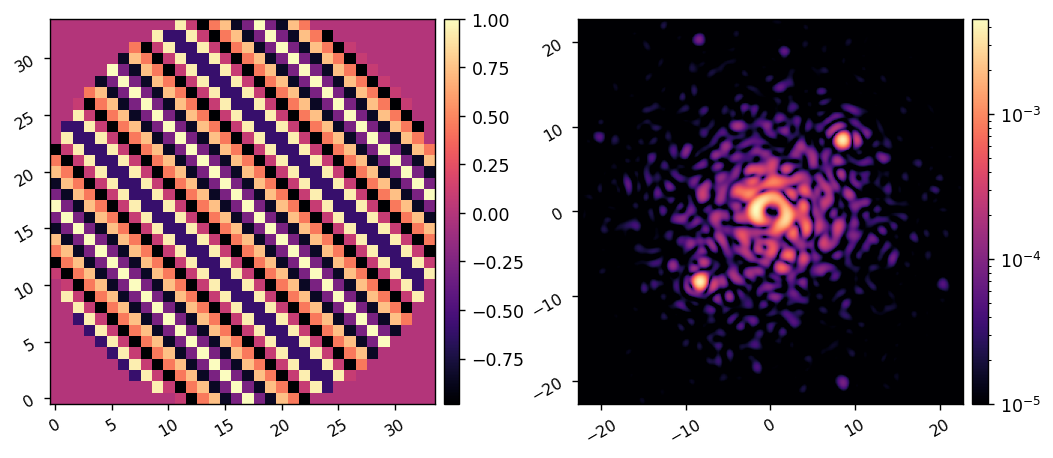

In [199]:
def create_sin_command(x_cpa=10, y_cpa=10, Nact=34):
    # cpa = cycles per aperture
    # max cpa must be Nact/2
    if x_cpa>Nact/2 or y_cpa>Nact/2:
        raise ValueError('The cycles per aperture is too high for the specified number of actuators.')
    y,x = xp.indices((Nact, Nact)) - Nact//2
    sin_command = xp.cos(2*np.pi*(x_cpa*x + y_cpa*y)/Nact)
    return sin_command

sin_command = create_sin_command(x_cpa=10, y_cpa=10)
sin_acts = 10e-9 * ensure_np_array(sin_command[m.dm_mask])

sin_im = xp.abs(m.forward(sin_acts, use_vortex=True, use_wfe=True))**2
imshow2(sin_command*m.dm_mask, sin_im, pxscl2=m.psf_pixelscale_lamD, lognorm2=True,  vmin2=1e-5)

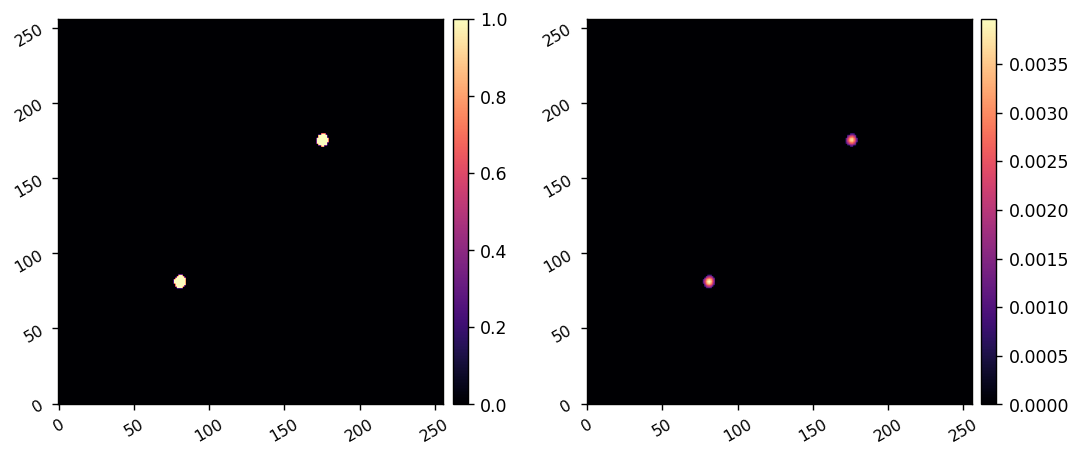

Centroids:
 [[ 80.71531095  80.8760777 ]
 [175.49035678 175.04401678]]


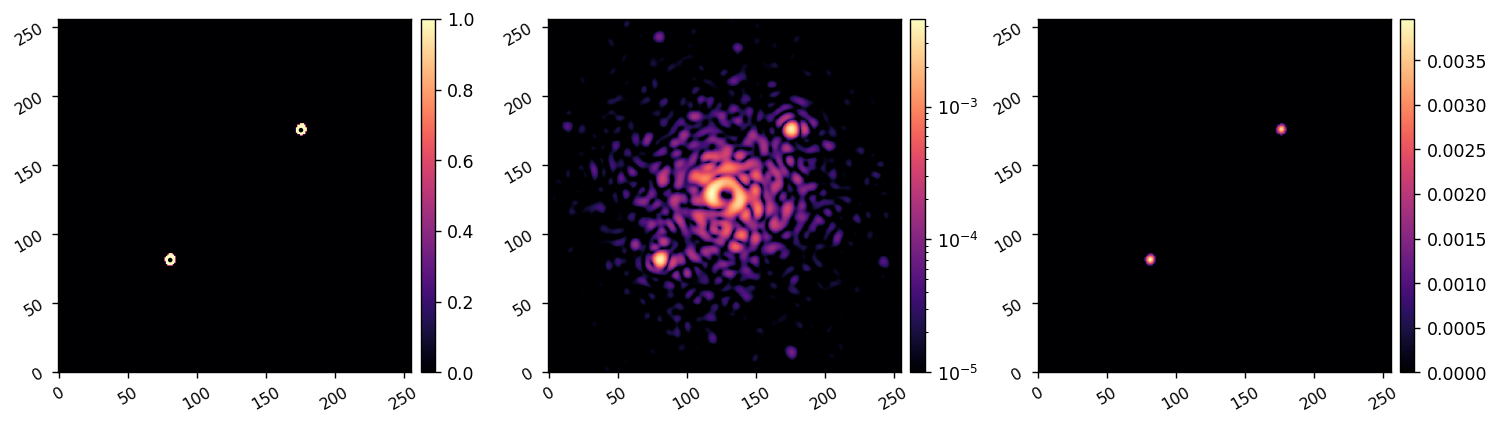

In [208]:
def measure_pixelscale(sin_im, cpa, 
                       dm_diam=10.2, dm_lyot_mag=9.4/9.4, lyot_diam=8.6, 
                       im_thresh=1e-4, r_thresh=50, 
                       verbose=True, plot=True,):
    npsf = sin_im.shape[0]
    y,x = (xp.indices((npsf, npsf)) - npsf//2)
    r = xp.sqrt(x**2 + y**2)
    sin_mask = (sin_im >im_thresh) * (r>r_thresh)
    imshow2(sin_mask, sin_mask*sin_im)

    centroids = []
    for i in [0,1]:
        arr = sin_im[:, i*npsf//2:(i+1)*m.npsf//2]
        mask = sin_mask[:, i*npsf//2:(i+1)*npsf//2]
        cent = np.flip(skimage.measure.centroid(ensure_np_array(mask*arr)))
        cent[0] += i*npsf//2
        centroids.append(cent)
        # print(cent)
        # imshow3(mask, arr, mask*arr, lognorm2=True,
        #         patches1=[Circle(cent, 1, fill=True, color='cyan')])
    centroids = np.array(centroids)
    if verbose: print('Centroids:\n', centroids)

    if plot: 
        patches = []
        for i in range(2):
            patches.append(Circle(centroids[i], 1, fill=True, color='black'))
        imshow3(sin_mask, sin_im, sin_mask*sin_im, lognorm2=True, vmin2=1e-5,
                patches1=patches)

    sep_pix = np.sqrt((centroids[1][0] - centroids[0][0])**2 + (centroids[1][1] - centroids[0][1])**2)
    pixelscale_lamD = (2*cycles_per_ap) / sep_pix * lyot_diam/(dm_diam * dm_lyot_mag)

    return pixelscale_lamD

pixelscale_lamD = measure_pixelscale(sin_im, cpa=10*np.sqrt(2), im_thresh=1e-3, r_thresh=30)

In [209]:
m.psf_pixelscale_lamD, pixelscale_lamD

(0.17767032967032964, 0.1784946718836868)

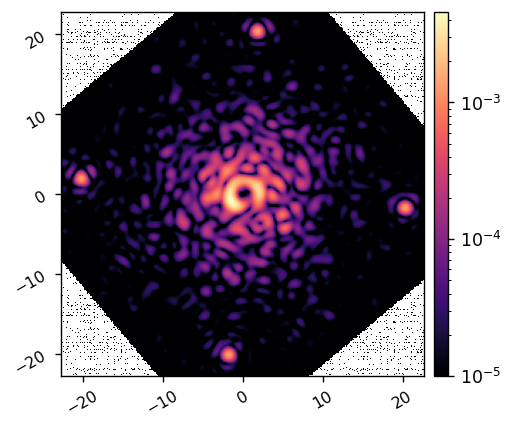

In [143]:
def create_waffle_command(Nact=34):
    waffle_command = xp.ones((Nact,Nact))
    waffle_command[1::2, ::2] *= -1
    waffle_command[::2, 1::2] *= -1
    return waffle_command
waffle_acts = 15e-9*ensure_np_array(create_waffle_command()[m.dm_mask])

waffle_im = xp.abs(m.forward(waffle_acts, use_vortex=True, use_wfe=True))**2
imshow1(waffle_im, pxscl=m.psf_pixelscale_lamD, lognorm=True,  vmin=1e-5)

Centroids:
 [[117.48297934  14.51568347]
 [ 13.863919   138.27679717]
 [137.79148578 241.8799857 ]
 [241.68242991 117.74940461]
 [117.48297934  14.51568347]]


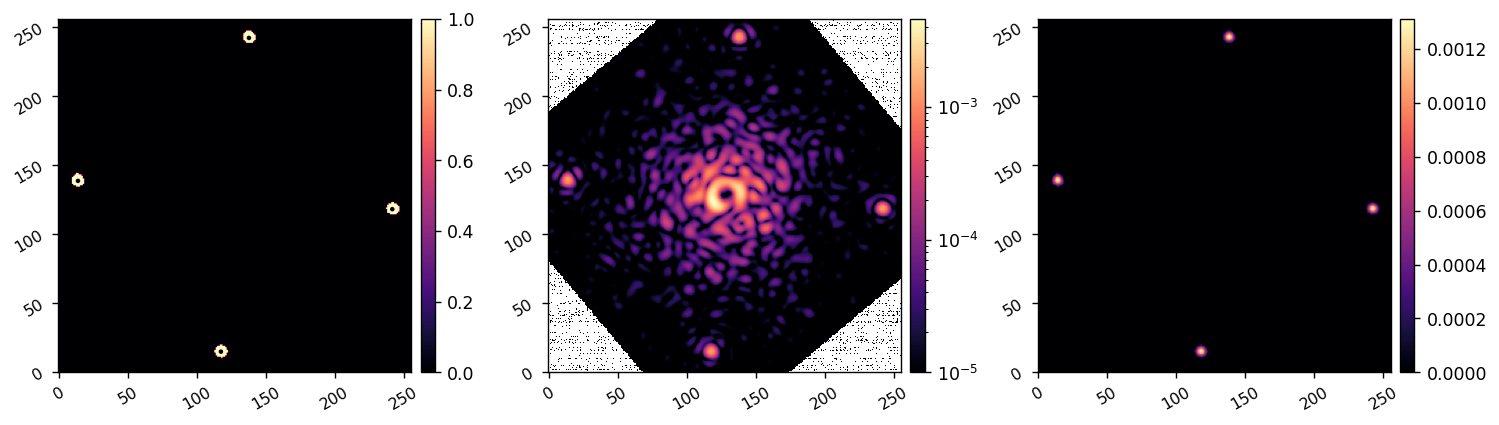

Angle:  50.12648563543767


In [144]:
def measure_detector_angle(waffle_im, npsf, psf_pixelscale_lamD, im_thresh=1e-4, r_thresh=12,
                           verbose=True, 
                           plot=True):
    # x,y = utils.make_grid(npsf, psf_pixelscale_lamD, )
    y,x = (xp.indices((npsf, npsf)) - npsf//2)*psf_pixelscale_lamD
    r = xp.sqrt(x**2 + y**2)
    waffle_mask = (waffle_im >im_thresh) * (r>r_thresh)

    centroids = []
    for i in [0,1]:
        for j in [0,1]:
            arr = waffle_im[j*m.npsf//2:(j+1)*m.npsf//2, i*m.npsf//2:(i+1)*m.npsf//2]
            mask = waffle_mask[j*m.npsf//2:(j+1)*m.npsf//2, i*m.npsf//2:(i+1)*m.npsf//2]
            cent = np.flip(skimage.measure.centroid(ensure_np_array(mask*arr)))
            cent[0] += i*m.npsf//2
            cent[1] += j*m.npsf//2
            centroids.append(cent)
            # print(cent)
            # imshow3(mask, arr, mask*arr, lognorm2=True,
            #         patches1=[Circle(cent, 1, fill=True, color='cyan')])
    centroids.append(centroids[0])
    centroids = np.array(centroids)
    centroids[[2,3]] = centroids[[3,2]]
    if verbose: print('Centroids:\n', centroids)

    if plot: 
        patches = []
        for i in range(4):
            patches.append(Circle(centroids[i], 1, fill=True, color='black'))
        imshow3(waffle_mask, waffle_im, waffle_mask*waffle_im, lognorm2=True, vmin2=1e-5,
                patches1=patches)

    mean_angle = 0.0
    for i in range(4):
        angle = np.arctan2(centroids[i+1][1] - centroids[i][1], centroids[i+1][0] - centroids[i][0]) * 180/np.pi
        if angle<0:
            angle += 360
        if 0<angle<90:
            angle = 90-angle
        elif 90<angle<180:
            angle = 180-angle
        elif 180<angle<270:
            angle = 270-angle
        elif 270<angle<360:
            angle = 360-angle
        mean_angle += angle/4
    if verbose: print('Angle: ', mean_angle)

    return mean_angle

angle = measure_detector_angle(waffle_im, m.npsf, m.psf_pixelscale_lamD, im_thresh=2e-4, r_thresh=12)

